# **Lab11-1: Convolution Neural Networks**

110062209 簡晟棋

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [2]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

In [4]:
!gdown --id 1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx
!unzip -qq -u oregon_wildlife.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx
From (redirected): https://drive.google.com/uc?id=1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx&confirm=t&uuid=cdaaf871-ede9-4e82-8c0f-eded32504177
To: /content/oregon_wildlife.zip
100% 2.45G/2.45G [00:34<00:00, 71.6MB/s]


In [3]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/raven
oregon_wildlife/deer
oregon_wildlife/cougar
oregon_wildlife/sea_lions
oregon_wildlife/virginia_opossum
oregon_wildlife/bald_eagle
oregon_wildlife/nutria
oregon_wildlife/raccoon
oregon_wildlife/black_bear
oregon_wildlife/red_fox

total img num: 7168


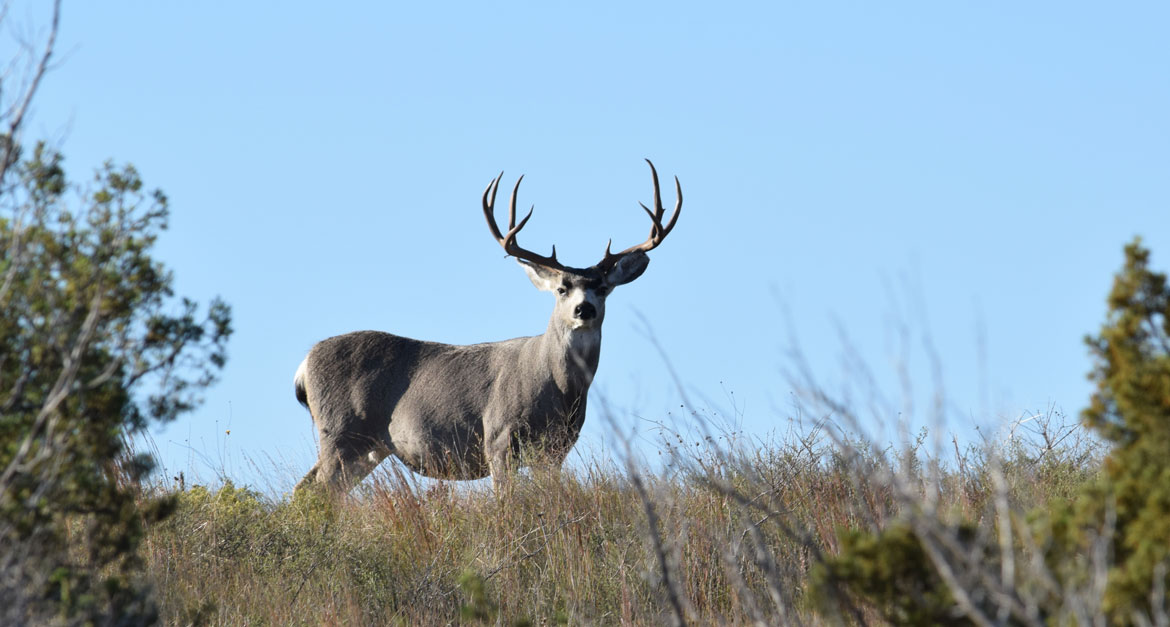

deer


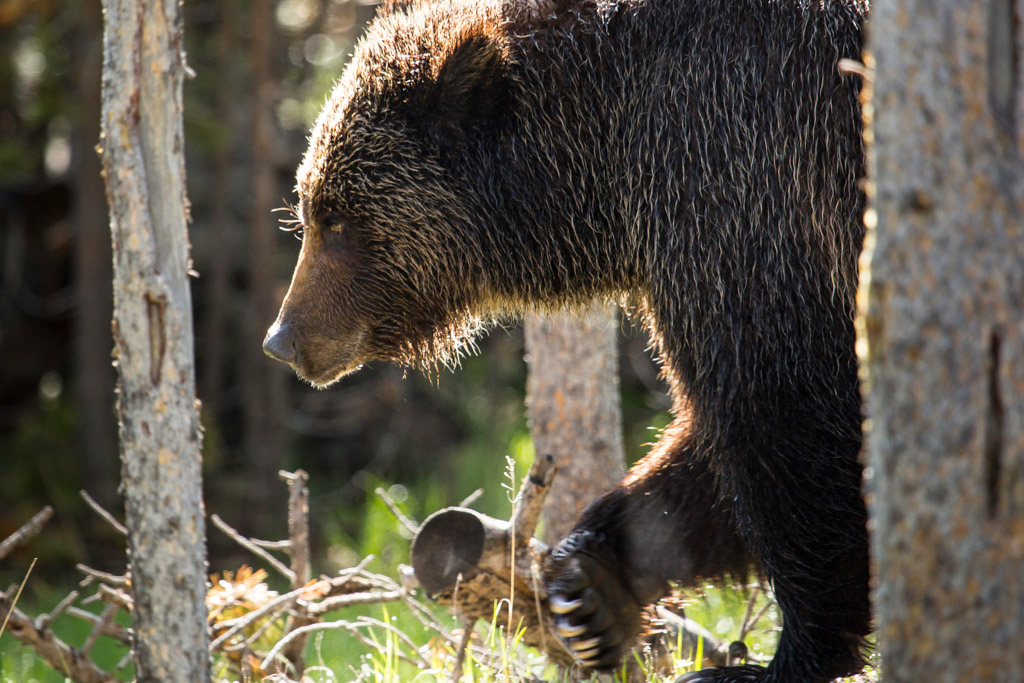

black_bear


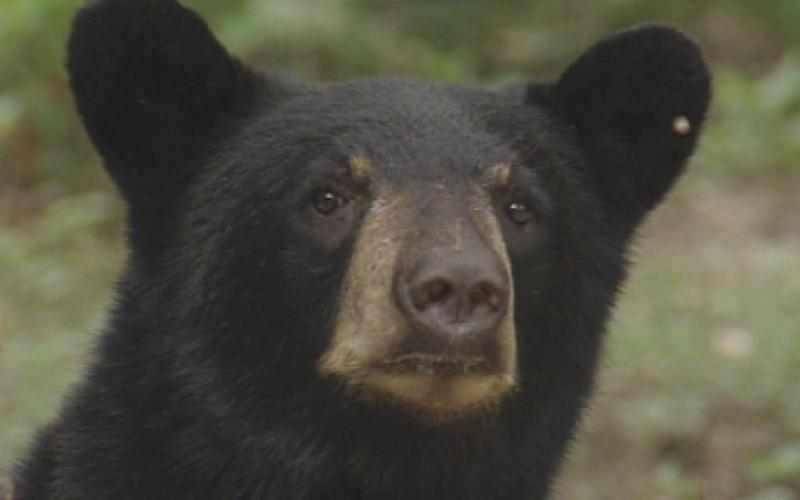

black_bear


In [4]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [5]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [6]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [1, 0, 2, 0, 3, 2, 3, 6, 3, 6]


In [8]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [9]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])

with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [10]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [11]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------

        # Reading the file
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [12]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [13]:
# feel free to modify these two Settings.
BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [ ]:
dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

In [14]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [ ]:
# save the initialization of weights
wild_model.save_weights('wild_model.weights.h5')

In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [16]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)

@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [17]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_state()
        train_accuracy.reset_state()
        test_loss.reset_state()
        test_accuracy.reset_state()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.1)

            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter

            time.sleep(0.1)

            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.1)

            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter

            time.sleep(0.1)

            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [ ]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  11575.561346172
training:


100%|██████████| 179/179 [03:21<00:00,  1.13s/it]

testing:



100%|██████████| 44/44 [00:37<00:00,  1.18it/s]

Epoch 1, Loss: 5.9032, Accuracy: 27.2172, test Loss: 1.3345, test Accuracy: 62.8551
training:



100%|██████████| 179/179 [02:40<00:00,  1.11it/s]

testing:



100%|██████████| 44/44 [00:35<00:00,  1.24it/s]

Epoch 2, Loss: 1.5895, Accuracy: 42.9818, test Loss: 1.1160, test Accuracy: 65.5540
training:



100%|██████████| 179/179 [02:37<00:00,  1.13it/s]

testing:



100%|██████████| 44/44 [00:35<00:00,  1.24it/s]

Epoch 3, Loss: 1.2930, Accuracy: 52.8457, test Loss: 0.8121, test Accuracy: 78.4801
Execution time: 628.8725021699993


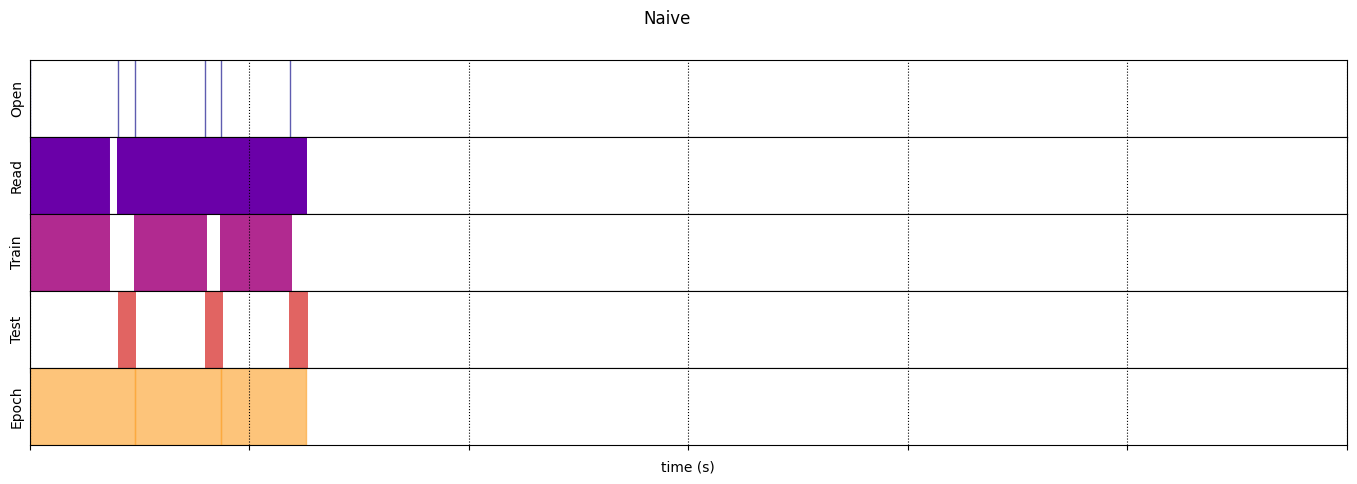

In [ ]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=3000)

1. only data augmentation

    training:使用Shuffle ,random flip (left or right), random brightness, random contrast, standardization

    testing:使用standardization

In [18]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map
def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.float32)
        )
    return wrapper

In [20]:

@map_decorator
def map_fun(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)

    # record the enter time into map_fun()
    map_enter = time.perf_counter()

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    label = tf.cast(label, tf.float32)
    map_elapsed = time.perf_counter() - map_enter
    # ----------------

    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

@map_decorator
def map_fun_test(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)

    # record the enter time into map_fun_test()
    map_enter = time.perf_counter()


    distorted_image = tf.image.per_image_standardization(image)
    label = tf.cast(label, tf.float32)
    map_elapsed = time.perf_counter() - map_enter
    # ----------------

    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label
dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .map(map_fun)\
                                        .shuffle(BUFFER_SIZE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)

dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                        .map(map_fun_test)\
                                        .batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.weights.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  1755.862876417
training:


100%|██████████| 179/179 [14:21<00:00,  4.82s/it]

testing:



100%|██████████| 44/44 [03:13<00:00,  4.39s/it]

Epoch 1, Loss: 3.5710, Accuracy: 58.1355, test Loss: 0.3891, test Accuracy: 87.8551
training:



100%|██████████| 179/179 [14:21<00:00,  4.82s/it]

testing:



100%|██████████| 44/44 [03:13<00:00,  4.39s/it]

Epoch 2, Loss: 0.5519, Accuracy: 82.5419, test Loss: 0.2658, test Accuracy: 92.1165
training:



100%|██████████| 179/179 [14:21<00:00,  4.82s/it]

testing:



100%|██████████| 44/44 [03:10<00:00,  4.34s/it]

Epoch 3, Loss: 0.3782, Accuracy: 87.6397, test Loss: 0.2451, test Accuracy: 91.7614
Execution time: 3163.0616848500003


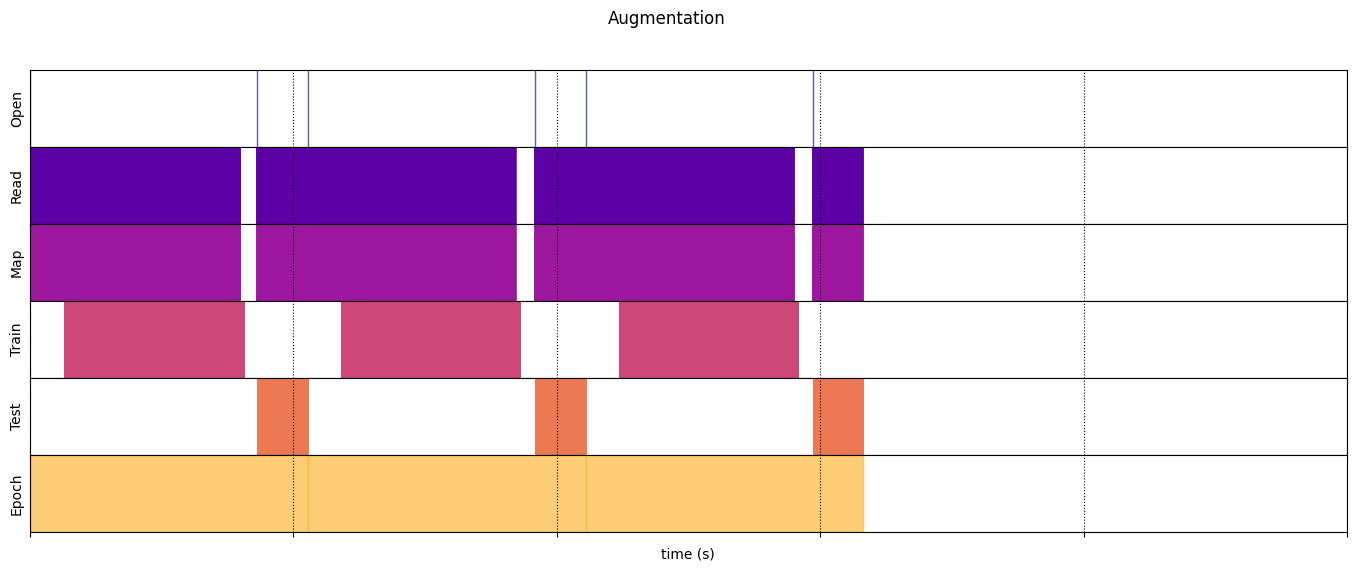

In [ ]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=5000)

data augmentation雖然耗時上升不少(629->3163)，但也使(train Accuracy,test Accuracy)也從(53%,78%)上升到(88%,91%)，有顯著的改善。



---



2. data augmentation + optimiztion

    data augmentation與上面一樣

    optimiztion使用Interleave、Parallel mapping、cache、prefetch與Vectorizing mapping

In [19]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated
@map_decorator
def map_fun_batch(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)

    # record the enter time into map_fun()
    map_enter = time.perf_counter()

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    label = tf.cast(label, tf.float32)
    map_elapsed = time.perf_counter() - map_enter
    # ----------------

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

@map_decorator
def map_fun_test_batch(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)

    # record the enter time into map_fun_test()
    map_enter = time.perf_counter()

    distorted_image = tf.image.per_image_standardization(image)
    label = tf.cast(label, tf.float32)
    map_elapsed = time.perf_counter() - map_enter
    # ----------------

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label


dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun_batch, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache('cache')\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun_test_batch, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache('cache')\
                                                  .prefetch(tf.data.AUTOTUNE)

In [20]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.weights.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  1706.556129699
training:


100%|██████████| 179/179 [01:40<00:00,  1.79it/s]

testing:



179it [01:14,  2.41it/s]

Epoch 1, Loss: 3.4161, Accuracy: 56.1453, test Loss: 0.3173, test Accuracy: 90.7472
training:



100%|██████████| 179/179 [02:21<00:00,  1.26it/s]

testing:



179it [01:21,  2.19it/s]

Epoch 2, Loss: 0.5663, Accuracy: 82.0880, test Loss: 0.1696, test Accuracy: 95.8275
training:



100%|██████████| 179/179 [01:31<00:00,  1.96it/s]

testing:



179it [01:21,  2.19it/s]

Epoch 3, Loss: 0.4592, Accuracy: 86.2430, test Loss: 0.0802, test Accuracy: 97.5210
Execution time: 571.8980469520002


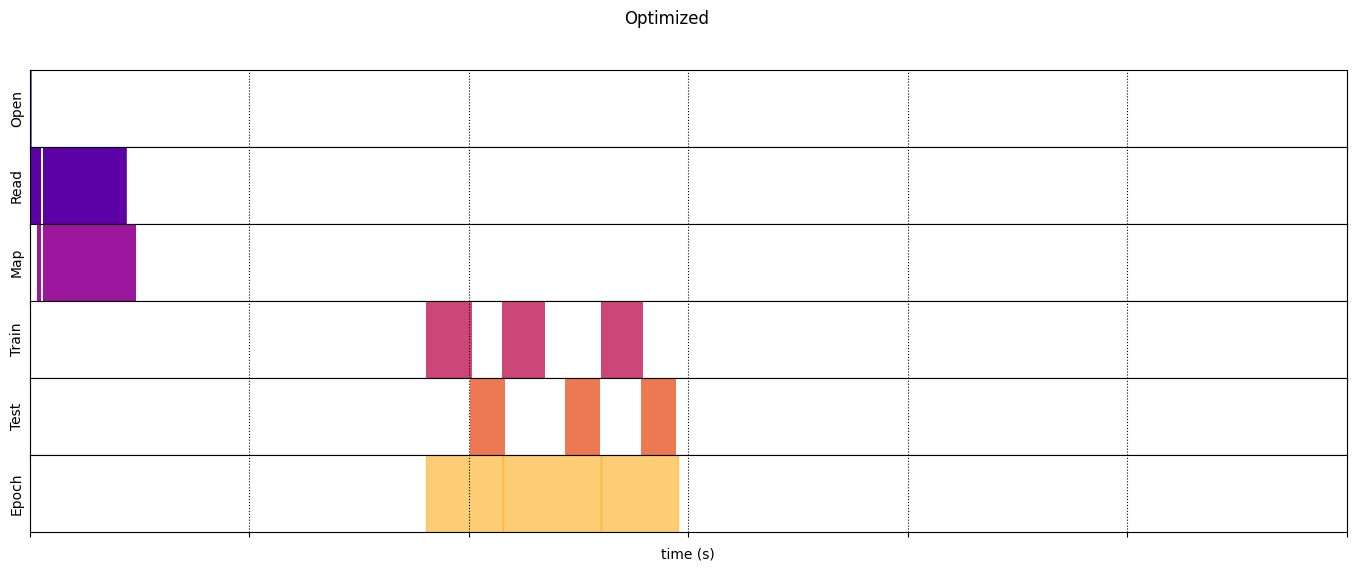

In [21]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=3000)

比起單純的data augmentation用時下降不少(3163->571)，map與read都在第1個epoch做完後不重複執行，每個epoch的用時也因平行化下降了許多

(train Accuracy,test Accuracy)從(88%,91%)變成(86%,98%)，train accuracy稍微下降，但test accuracy上升不少